<a href="https://colab.research.google.com/github/RamyaMN28/Diverse_Recommender-System-on-MovieLens-dataset-/blob/main/NCF_Based_Movie_Recommender_with_%CE%B5_Greedy_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dataset

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


## Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

## Combine the required columns in the dataset

In [ ]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
ratings_dataset['timestamp'] = pd.to_datetime(ratings_dataset['timestamp'], unit='s')
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,1997-12-04 15:55:49,Kolya (1996)
1,63,242,3,1997-10-01 23:06:30,Kolya (1996)
2,226,242,5,1998-01-04 04:37:51,Kolya (1996)
3,154,242,3,1997-11-10 05:03:55,Kolya (1996)
4,306,242,5,1997-10-10 17:16:33,Kolya (1996)


## Analysing the Dataset

In [ ]:
final_df = merged_dataset.groupby(by=['user id', 'movie title'], as_index=False).agg({
    "rating": "mean",
    "timestamp": "max"
})


In [ ]:
final_df.columns

Index(['user id', 'movie title', 'rating', 'timestamp'], dtype='object')

In [ ]:
final_df.describe()

,user id,rating,timestamp
count,99693.000000,99693.000000,99693
mean,462.513366,3.529907,1997-12-31 00:18:02.720371712
min,1.000000,1.000000,1997-09-20 03:05:10
25%,254.000000,3.000000,1997-11-13 19:16:44
50%,447.000000,4.000000,1997-12-22 21:39:42
75%,682.000000,4.000000,1998-02-23 18:44:40
max,943.000000,5.000000,1998-04-22 23:10:38
std,266.619991,1.125492,NaN


In [ ]:
final_df.dtypes


user id                 int64
movie title            object
rating                float64
timestamp      datetime64[ns]
dtype: object

In [ ]:
final_df.shape

(99693, 4)

In [ ]:
final_df.isnull().sum()

user id        0
movie title    0
rating         0
timestamp      0
dtype: int64

## Some plots for Reference

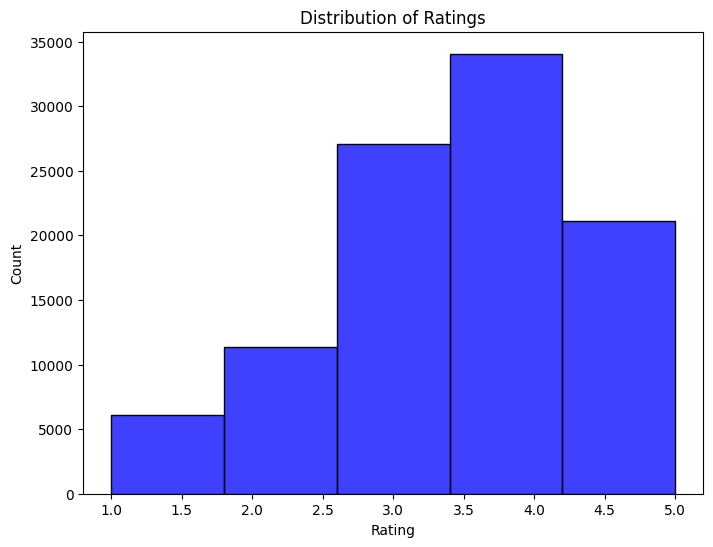

In [ ]:
# Plotting histogram of ratings
plt.figure(figsize=(8, 6))
sns.histplot(final_df['rating'], bins=5, kde=False, color='blue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


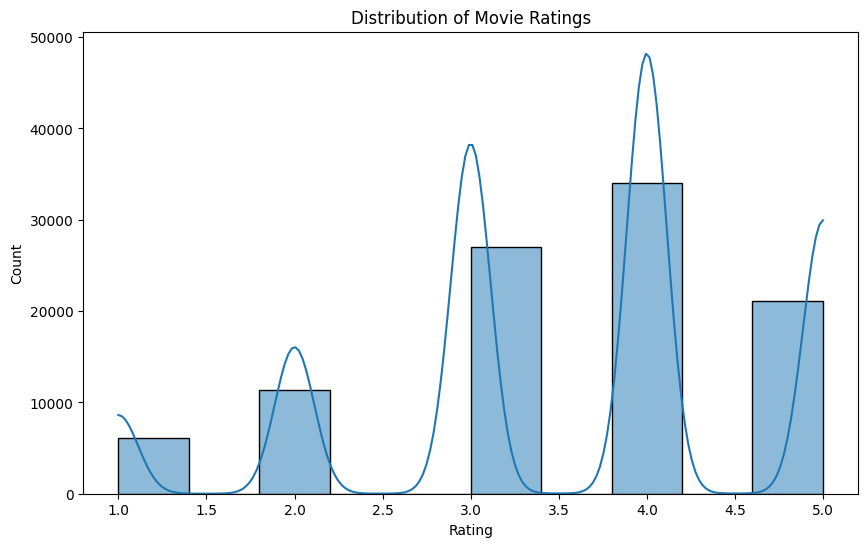

In [ ]:
# The distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(final_df['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


<ipython-input-135-5618dc7e445f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_ratings_count.values, y=movie_ratings_count.index, palette='viridis')


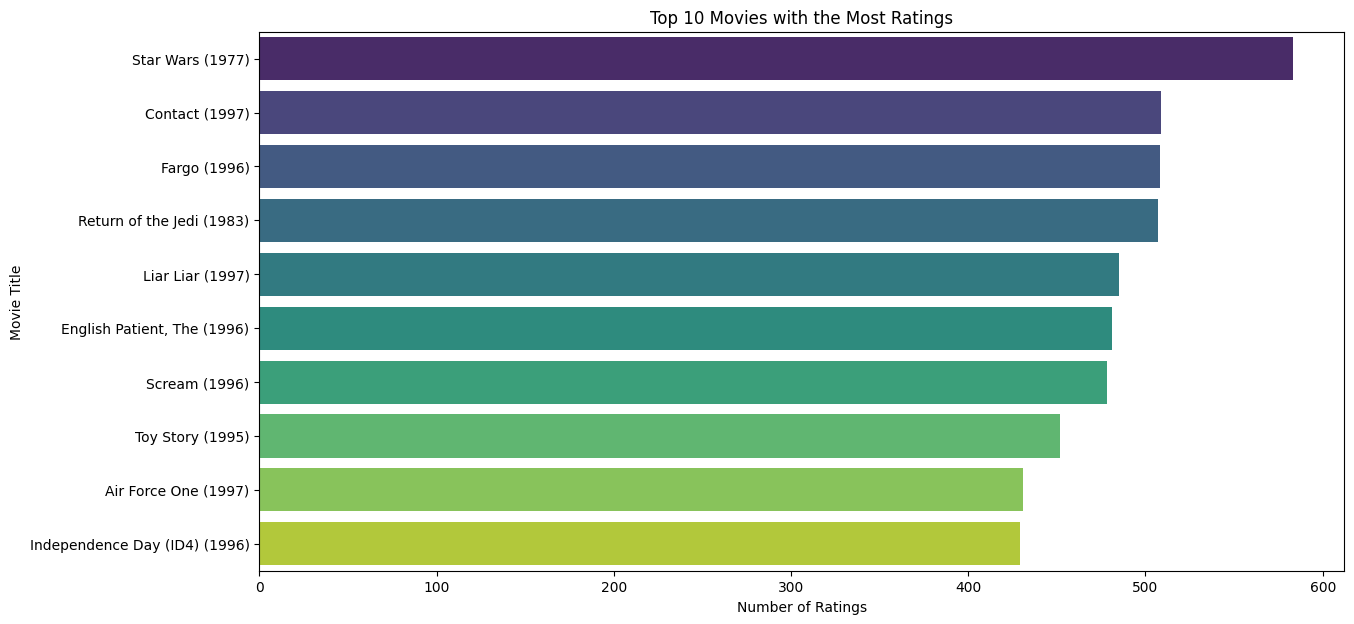

In [ ]:
# The top 10 movies with the most ratings
movie_ratings_count = final_df.groupby('movie title')['rating'].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x=movie_ratings_count.values, y=movie_ratings_count.index, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


## Data Preparation

In [ ]:

# Encode user_id and movie_title
user_encoder = LabelEncoder()
final_df['user_id'] = user_encoder.fit_transform(final_df['user id'])

movie_encoder = LabelEncoder()
final_df['movie_id'] = movie_encoder.fit_transform(final_df['movie title'])

final_df.drop(['user id', 'movie title'], axis=1, inplace=True)


## Split Data into Train and Test Sets

In [ ]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)


## **Build Neural Collaborative Filtering (NCF) Model**

### NCF typically combines matrix factorization and neural networks to learn user-item embeddings and make recommendations.

In [ ]:
# Constants
num_users = len(final_df['user_id'].unique())
num_movies = len(final_df['movie_id'].unique())
embedding_size = 50  # Size of user and movie embeddings

# Input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# User and movie embeddings
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

# Flatten embeddings
user_flatten = Flatten()(user_embedding)
movie_flatten = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = Concatenate()([user_flatten, movie_flatten])

# Neural network layers
dense1 = Dense(64, activation='relu')(concat)
dropout = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout)
output = Dense(1, activation='linear')(dense2)  # Linear activation for regression

# Model instantiation
ncf_model = Model(inputs=[user_input, movie_input], outputs=output)

# Compile model
ncf_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
print(ncf_model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                47150     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 50)                83200     ['movie_input[0][0]']         
 )                                                                                          

# Train the NCF Model

In [ ]:
# Define training inputs
X_train = [train_df['user_id'].values, train_df['movie_id'].values]
y_train = train_df['rating'].values

# Train the model
history = ncf_model.fit(X_train, y_train, batch_size=64, epochs=30, validation_split=0.2)


Epoch 1/30
997/997 [==============================] - 8s 6ms/step - loss: 1.5729 - mae: 0.9412 - val_loss: 0.9272 - val_mae: 0.7603
Epoch 2/30
997/997 [==============================] - 8s 8ms/step - loss: 0.9424 - mae: 0.7720 - val_loss: 0.9135 - val_mae: 0.7660
Epoch 3/30
997/997 [==============================] - 5s 5ms/step - loss: 0.9135 - mae: 0.7590 - val_loss: 0.8956 - val_mae: 0.7531
Epoch 4/30
997/997 [==============================] - 6s 6ms/step - loss: 0.8721 - mae: 0.7396 - val_loss: 0.8949 - val_mae: 0.7392
Epoch 5/30
997/997 [==============================] - 5s 5ms/step - loss: 0.8413 - mae: 0.7260 - val_loss: 0.8842 - val_mae: 0.7408
Epoch 6/30
997/997 [==============================] - 5s 5ms/step - loss: 0.8148 - mae: 0.7122 - val_loss: 0.8842 - val_mae: 0.7470
Epoch 7/30
997/997 [==============================] - 5s 5ms/step - loss: 0.7868 - mae: 0.6987 - val_loss: 0.8763 - val_mae: 0.7357
Epoch 8/30
997/997 [==============================] - 5s 5ms/step - loss: 0.

# Evaluate the Model

In [ ]:
# Evaluate on test data
X_test = [test_df['user_id'].values, test_df['movie_id'].values]
y_test = test_df['rating'].values

results = ncf_model.evaluate(X_test, y_test)
print(f"Test MSE: {results[0]}, Test MAE: {results[1]}")


624/624 [==============================] - 2s 3ms/step - loss: 1.0051 - mae: 0.7727
Test MSE: 1.0051298141479492, Test MAE: 0.7726855278015137


## Generate Recommendations for Users

In [ ]:
user_id = int(input("May I Know Your user_id "))
user_movies = final_df[final_df['user_id'] == user_id]['movie_id'].unique()
last_watched_movie = final_df[final_df['user_id'] == user_id].sort_values(by='timestamp', ascending=False)['movie_id'].values[0]
last_watched_movie_title = movie_encoder.inverse_transform([last_watched_movie])[0]

all_movies = np.array(list(set(final_df['movie_id'].unique()) - set(user_movies)))

user_input = np.full((len(all_movies), 1), user_id)
movie_input = all_movies.reshape(-1, 1)

predicted_ratings = ncf_model.predict([user_input, movie_input]).flatten()

top_indices = (-predicted_ratings).argsort()[:10]
top_movie_ids = all_movies[top_indices]
top_movie_titles = movie_encoder.inverse_transform(top_movie_ids)
top_ratings = predicted_ratings[top_indices]
print(f"\nSince you last watched '{last_watched_movie_title}', we recommend these movies.")
print(f"Top 10 Recommendations for User {user_id}:")
for rank, (movie_title, rating) in enumerate(zip(top_movie_titles, top_ratings), 1):
    print(f"{rank}. {movie_title} - Rating: {rating:.2f}")



May I Know Your user_id 5
46/46 [==============================] - 0s 2ms/step

Since you last watched 'Good Will Hunting (1997)', we recommend these movies.
Top 10 Recommendations for User 5:
1. Anna (1996) - Rating: 5.58
2. Saint of Fort Washington, The (1993) - Rating: 5.06
3. Star Kid (1997) - Rating: 5.00
4. Schizopolis (1996) - Rating: 4.97
5. Guantanamera (1994) - Rating: 4.91
6. Boys, Les (1997) - Rating: 4.86
7. Horseman on the Roof, The (Hussard sur le toit, Le) (1995) - Rating: 4.85
8. Gabbeh (1996) - Rating: 4.85
9. Someone Else's America (1995) - Rating: 4.74
10. Faust (1994) - Rating: 4.73


## **Bias and Fairness** is a challenge for recommendation systems
One significant challenge in our movie recommendation system is the tendency to disproportionately recommend highly-rated or popular movies, which can overshadow lesser-known yet potentially enjoyable films. This bias not only reinforces existing trends but also risks excluding underrated movies that might align well with individual user preferences, leading to a lack of diversity in recommendations and potentially diminishing user satisfaction by not reflecting their unique tastes

## Explore Rating Distribution

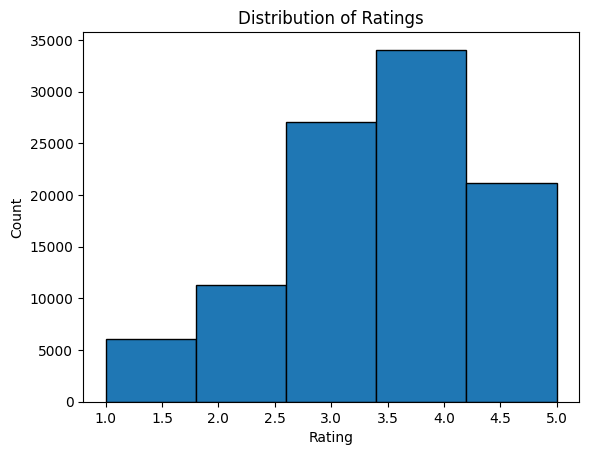

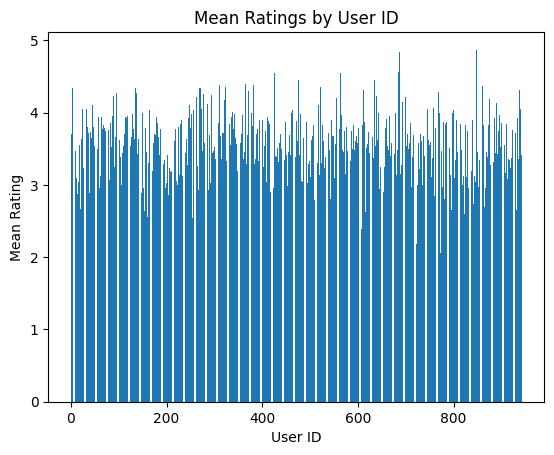

In [ ]:
mean_ratings_by_user = final_df.groupby('user_id')['rating'].mean()
# Visualize distribution of ratings
plt.hist(final_df['rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

# Compare ratings distribution across user ids if applicable
plt.bar(mean_ratings_by_user.index, mean_ratings_by_user.values)
plt.xlabel('User ID')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings by User ID')
plt.show()


In [ ]:
# Normalize ratings
user_mean_ratings = final_df.groupby('user_id')['rating'].transform('mean')
final_df['normalized_rating'] = final_df['rating'] - user_mean_ratings



**Explore-exploit techniques** are essential for balancing between recommending popular items that are likely to be well-received (exploitation) and exploring new items to improve recommendation diversity and novelty (exploration).

**ε-Greedy Exploration:** Assign a small probability ε (epsilon) to explore new items randomly rather than always recommending the best-known option. Adjust ε based on user feedback and engagement metrics.

To implement a complete recommendation system with ε-greedy exploration, let's integrate it with our dataset and NCF model.

In [ ]:
import numpy as np

def recommend_items(user_id, final_df, ncf_model, movie_encoder, epsilon=0.1, top_n=10):
    if np.random.rand() < epsilon:
        recommended_items, ratings = explore_new_items(user_id, final_df, top_n)
    else:
        recommended_items, ratings = exploit_known_items(user_id, final_df, ncf_model, movie_encoder, top_n)

    last_watched_movies = final_df[final_df['user_id'] == user_id].sort_values(by='timestamp', ascending=False).head(top_n)

    combined_output = [(item, rating) for item, rating in zip(recommended_items, ratings)]

    return combined_output, last_watched_movies

def explore_new_items(user_id, final_df, top_n):

    all_movie_ids = final_df['movie_id'].unique()
    random_movie_ids = np.random.choice(all_movie_ids, size=top_n, replace=False)
    random_ratings = np.round(np.random.uniform(0, 5, size=top_n), 2)
    return random_movie_ids, random_ratings

def exploit_known_items(user_id, final_df, ncf_model, movie_encoder, top_n):
    user_movies = final_df[final_df['user_id'] == user_id]['movie_id'].unique()
    all_movies = np.array(list(set(final_df['movie_id'].unique()) - set(user_movies)))

    user_input = np.full((len(all_movies), 1), user_id)
    movie_input = all_movies.reshape(-1, 1)

    predicted_ratings = ncf_model.predict([user_input, movie_input]).flatten()

    top_movie_ids = all_movies[(-predicted_ratings).argsort()[:top_n]]  # Top N recommended movie IDs
    top_ratings = np.round(predicted_ratings[(-predicted_ratings).argsort()[:top_n]], 2)  # Corresponding ratings rounded to two decimal places

    return top_movie_ids, top_ratings

user_id = int(input("Please enter your user_id: "))
epsilon = 0.1
top_n = 10
recommended_items, last_watched_movies = recommend_items(user_id, final_df, ncf_model, movie_encoder, epsilon, top_n)

print(f"Top {top_n} Recommendations for User {user_id}:")
for rank, (movie_id, rating) in enumerate(recommended_items, 1):
    movie_title = movie_encoder.inverse_transform([movie_id])[0]
    print(f"{rank}. {movie_title} (Rating: {rating:.2f})")

print("\nLast Recently Watched Movies:")
for index, row in last_watched_movies.iterrows():
    movie_title = movie_encoder.inverse_transform([row['movie_id']])[0]
    print(f"{movie_title} (Watched at: {row['timestamp']})")


Please enter your user_id: 4
Top 10 Recommendations for User 4:
1. An Unforgettable Summer (1994) (Rating: 0.25)
2. Corrina, Corrina (1994) (Rating: 2.15)
3. Salut cousin! (1996) (Rating: 4.93)
4. Last Summer in the Hamptons (1995) (Rating: 4.52)
5. Jane Eyre (1996) (Rating: 4.54)
6. Godfather: Part II, The (1974) (Rating: 2.48)
7. Room with a View, A (1986) (Rating: 1.44)
8. Mediterraneo (1991) (Rating: 2.79)
9. Man of No Importance, A (1994) (Rating: 0.09)
10. Turbo: A Power Rangers Movie (1997) (Rating: 3.67)

Last Recently Watched Movies:
Jaws 3-D (1983) (Watched at: 1997-11-10 21:54:58)
Amityville Curse, The (1990) (Watched at: 1997-11-10 21:54:58)
Robin Hood: Men in Tights (1993) (Watched at: 1997-11-10 21:54:58)
Free Willy 3: The Rescue (1997) (Watched at: 1997-11-10 21:54:58)
Beverly Hills Cop III (1994) (Watched at: 1997-11-10 21:54:58)
Rumble in the Bronx (1995) (Watched at: 1997-11-10 21:43:49)
Kingpin (1996) (Watched at: 1997-11-10 21:43:03)
To Wong Foo, Thanks for Everythi

# **Conclusion:**
### you can create a recommendation system that balances recommending popular items with introducing users to new and potentially interesting content.

Author - Ramya M N